In [4]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra 
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/akhil-home-dataset/akhil_home_dataset/akhil_home_dataset/m_test_combined.csv
/kaggle/input/akhil-home-dataset/akhil_home_dataset/akhil_home_dataset/m_test_small.csv
/kaggle/input/akhil-home-dataset/akhil_home_dataset/akhil_home_dataset/m_train_small.csv
/kaggle/input/akhil-home-dataset/akhil_home_dataset/akhil_home_dataset/m_train_combined.csv
/kaggle/input/akhil-home-dataset/pre_dataset/pre_dataset/train_previous_raw.csv
/kaggle/input/akhil-home-dataset/pre_dataset/pre_dataset/test_previous_raw.csv
/kaggle/input/akhil-home-dataset/pre_dataset/pre_dataset/train_bureau_raw.csv
/kaggle/input/akhil-home-dataset/pre_dataset/pre_dataset/test_bureau_raw.csv
/kaggle/input/home-credit-manual-engineered-features/train_previous_raw.csv
/kaggle/input/home-credit-manual-engineered-features/clean_manual.csv
/kaggle/input/home-credit-manual-engineered-features/test_previous_raw.csv
/kaggle/input/home-credit-manual-engineered-features/m_test_combined.csv
/kaggle/input/home-credit-manual

# Data


## Imports

In [5]:
import numpy as np
import pandas as pd
import os 
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import lightgbm as lgb
import gc
import matplotlib.pyplot as plt
import inspect

from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    roc_auc_score, accuracy_score, precision_score, 
    recall_score, f1_score, classification_report
)
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer


warnings.filterwarnings('ignore')


## Read Data


In [6]:
application_train=pd.read_csv('/kaggle/input/home-credit-default-risk/application_train.csv')
application_test=pd.read_csv('/kaggle/input/home-credit-default-risk/application_test.csv')
bureau_balance=pd.read_csv('/kaggle/input/home-credit-default-risk/bureau_balance.csv')
POS_CASH_balance=pd.read_csv('/kaggle/input/home-credit-default-risk/POS_CASH_balance.csv')
previous_application=pd.read_csv('/kaggle/input/home-credit-default-risk/previous_application.csv')
credit_card_balance=pd.read_csv('/kaggle/input/home-credit-default-risk/credit_card_balance.csv')
installments_payments=pd.read_csv('/kaggle/input/home-credit-default-risk/installments_payments.csv')
bureau=pd.read_csv('/kaggle/input/home-credit-default-risk/bureau.csv')

# Exploratory Data Analysis

In [7]:
application_train.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [8]:
print("application_train_shape:",application_train.shape)
print("application_test_shape",application_test.shape)

application_train_shape: (307511, 122)
application_test_shape (48744, 121)


<Axes: ylabel='Frequency'>

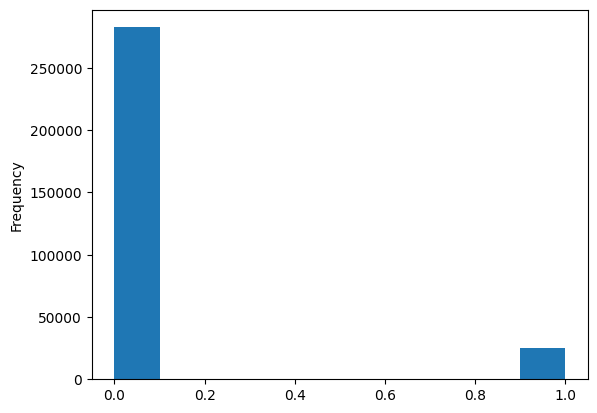

In [9]:
application_train['TARGET'].plot.hist()

class imbalance problem

## Missing Values

In [10]:
# function to calculate missing values
def missing_values(df):
    mis_val=df.isnull().sum().sort_values(ascending=False)
    mis_val_percent=(100*df.isnull().sum()/len(df)).sort_values(ascending=False)
    mis_val_table=pd.concat([mis_val,mis_val_percent],axis=1,keys=['Total_missing_values','Missing_values_percentage'])
    return mis_val_table

In [11]:
app_train_missing=missing_values(application_train)
app_train_missing.head(5)


,Total_missing_values,Missing_values_percentage
COMMONAREA_MEDI,214865,69.872297
COMMONAREA_AVG,214865,69.872297
COMMONAREA_MODE,214865,69.872297
NONLIVINGAPARTMENTS_MODE,213514,69.432963
NONLIVINGAPARTMENTS_AVG,213514,69.432963


## One hot encoding


In [12]:
def one_hot_encoder(df):
    df=pd.get_dummies(df)
    return df

In [13]:
application_train=one_hot_encoder(application_train)
application_test=one_hot_encoder(application_test)
print(application_train.shape)
print(application_test.shape)


(307511, 246)
(48744, 242)


## Remove Outliers and Anomalies

<Axes: >

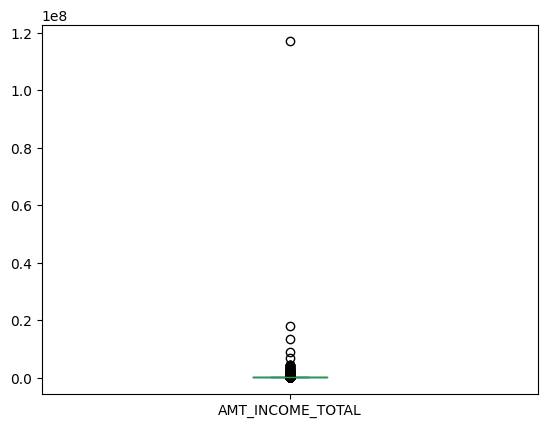

In [14]:
application_train['AMT_INCOME_TOTAL'].plot.box()

In [15]:
#some outliers around 1.75*1e7
application_train=application_train[application_train['AMT_INCOME_TOTAL']<20000000]
application_test=application_test[application_test['AMT_INCOME_TOTAL']<20000000]
application_train.shape

(307510, 246)

In [16]:
application_train['DAYS_LAST_PHONE_CHANGE'].describe()

count    307509.000000
mean       -962.861919
std         826.808008
min       -4292.000000
25%       -1570.000000
50%        -757.000000
75%        -274.000000
max           0.000000
Name: DAYS_LAST_PHONE_CHANGE, dtype: float64

In [17]:
application_train['DAYS_LAST_PHONE_CHANGE'].replace(0, np.nan, inplace=True)
application_test['DAYS_LAST_PHONE_CHANGE'].replace(0, np.nan, inplace=True)

<Axes: >

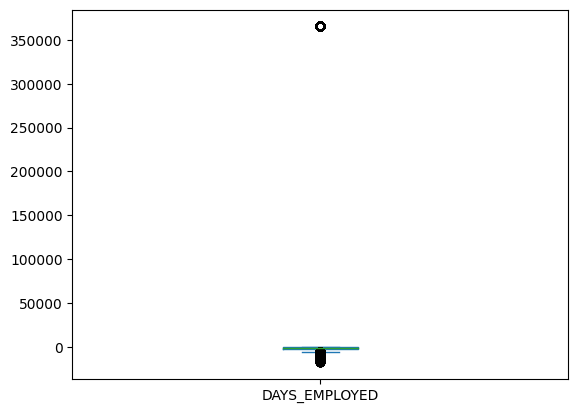

In [18]:
application_train['DAYS_EMPLOYED'].plot.box()

In [19]:
application_train['DAYS_EMPLOYED'].describe()

count    307510.000000
mean      63815.256424
std      141275.947995
min      -17912.000000
25%       -2760.000000
50%       -1213.500000
75%        -289.000000
max      365243.000000
Name: DAYS_EMPLOYED, dtype: float64

In [20]:
anom = application_train[application_train['DAYS_EMPLOYED'] == 365243]
non_anom = application_train[application_train['DAYS_EMPLOYED'] != 365243]
print('The non-anomalies default on %0.3f%% of loans' % (100 * non_anom['TARGET'].mean()))
print('The anomalies default on %0.3f%% of loans' % (100 * anom['TARGET'].mean()))
print('There are %d anomalous days of employment' % len(anom))

# They are less number of anomalies who are defaulters, 
#so there is some importance in anomalies,instead of removing those columns replace anomalies with Nan

The non-anomalies default on 8.660% of loans
The anomalies default on 5.400% of loans
There are 55374 anomalous days of employment


In [21]:
application_train['DAYS_EMPLOYED_ANOM'] = application_train["DAYS_EMPLOYED"] == 365243
application_train['DAYS_EMPLOYED'].replace({365243:np.nan},inplace=True)

In [22]:
(application_train['DAYS_BIRTH'] / -365).describe()

#minimum and maximum value is well in range of 20 anf 69 years

count    307510.000000
mean         43.937003
std          11.956141
min          20.517808
25%          34.008219
50%          43.150685
75%          53.923288
max          69.120548
Name: DAYS_BIRTH, dtype: float64

In [23]:
(application_train['DAYS_BIRTH']/ -365).value_counts()

DAYS_BIRTH
37.668493    43
36.934247    42
49.994521    41
27.452055    41
28.197260    40
             ..
68.213699     1
68.131507     1
21.964384     1
68.761644     1
68.660274     1
Name: count, Length: 17460, dtype: int64

In [24]:
#Correlations in Applications_train data set
correlations=application_train.corr()['TARGET'].sort_values()

print('Most Positive Correlations:\n', correlations.tail(15))
print('\nMost Negative Correlations:\n', correlations.head(15))

Most Positive Correlations:
 OCCUPATION_TYPE_Laborers                             0.042997
FLAG_DOCUMENT_3                                      0.044340
REG_CITY_NOT_LIVE_CITY                               0.044399
FLAG_EMP_PHONE                                       0.045978
NAME_EDUCATION_TYPE_Secondary / secondary special    0.049818
REG_CITY_NOT_WORK_CITY                               0.051001
DAYS_ID_PUBLISH                                      0.051463
CODE_GENDER_M                                        0.054722
DAYS_LAST_PHONE_CHANGE                               0.054900
NAME_INCOME_TYPE_Working                             0.057472
REGION_RATING_CLIENT                                 0.058901
REGION_RATING_CLIENT_W_CITY                          0.060894
DAYS_EMPLOYED                                        0.074952
DAYS_BIRTH                                           0.078232
TARGET                                               1.000000
Name: TARGET, dtype: float64

Most Negati

Text(0, 0.5, 'Count')

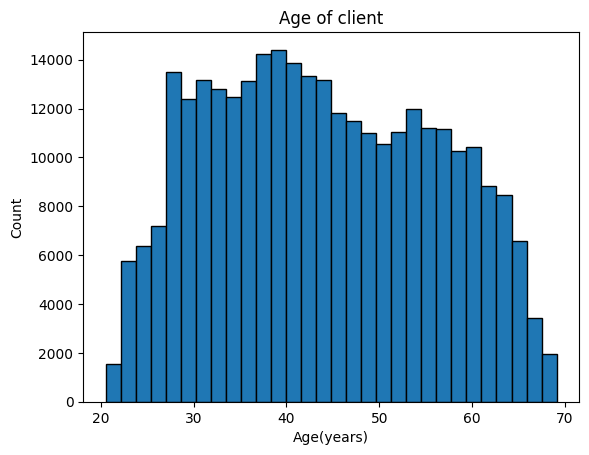

In [25]:
#DAYS_BIRTH has most positive correlation
application_train['DAYS_BIRTH']=abs(application_train['DAYS_BIRTH'])
plt.hist(application_train['DAYS_BIRTH']/365,edgecolor='k',bins=30)
plt.title('Age of client')
plt.xlabel('Age(years)')
plt.ylabel('Count')

In [26]:
#function for kde plt
def kde_plot(df, column_name):
    plt.figure(figsize=(6, 4))
    sns.kdeplot(df.loc[df['TARGET'] == 0, column_name], label='TARGET == 0')
    sns.kdeplot(df.loc[df['TARGET'] == 1, column_name], label='TARGET == 1')
    plt.xlabel(column_name)
    plt.ylabel('Density')
    plt.title(f'Distribution of {column_name} by TARGET')
    plt.legend()
    plt.show()

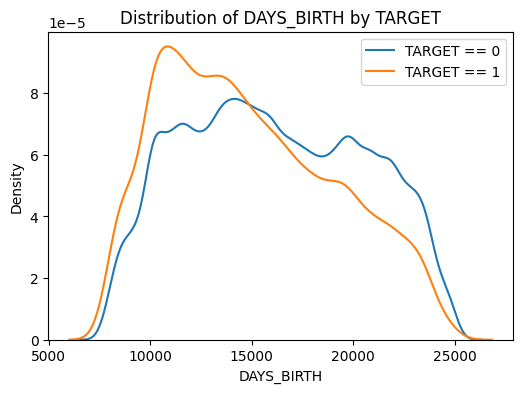

In [27]:
application_train['DAYS_BIRTH'] = application_train['DAYS_BIRTH'].replace([np.inf, -np.inf], np.nan)

kde_plot(application_train,'DAYS_BIRTH')

In [28]:
age_data=application_train[['TARGET','DAYS_BIRTH']]
age_data['YEARS_BIRTH']=age_data['DAYS_BIRTH']/365

age_data['YEARS_BINNED']=pd.cut(age_data['YEARS_BIRTH'],bins=np.linspace(20,70,num=11))
age_data.head()

,TARGET,DAYS_BIRTH,YEARS_BIRTH,YEARS_BINNED
0,1,9461,25.920548,"(25.0, 30.0]"
1,0,16765,45.931507,"(45.0, 50.0]"
2,0,19046,52.180822,"(50.0, 55.0]"
3,0,19005,52.068493,"(50.0, 55.0]"
4,0,19932,54.608219,"(50.0, 55.0]"


Text(0, 0.5, '%failure to repay')

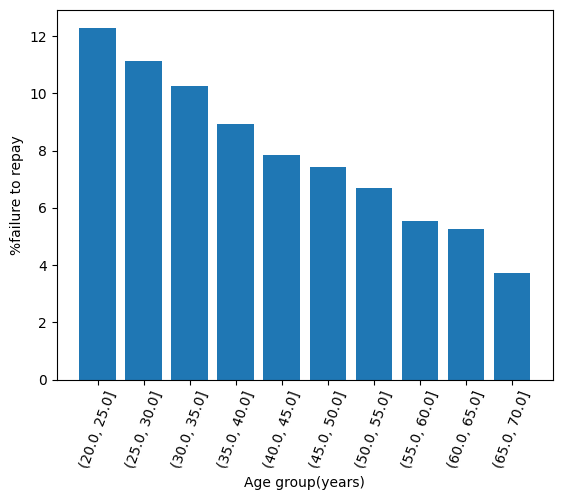

In [29]:
age_groups=age_data.groupby('YEARS_BINNED').mean()
plt.bar(age_groups.index.astype(str),100*age_groups['TARGET'])
plt.xticks(rotation=70)
plt.xlabel('Age group(years)')
plt.ylabel('%failure to repay')

younger clinets are more likely for defaulters

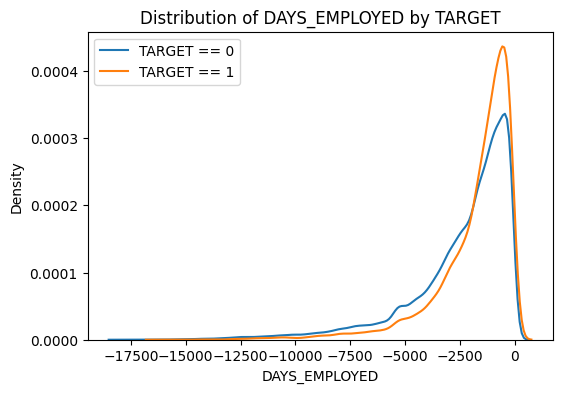

In [30]:
kde_plot(application_train,'DAYS_EMPLOYED')

In [31]:
#external source have more negative corelation
ext_data=application_train[['TARGET','EXT_SOURCE_1','EXT_SOURCE_2','EXT_SOURCE_3']]
ext_data_corrs=ext_data.corr()


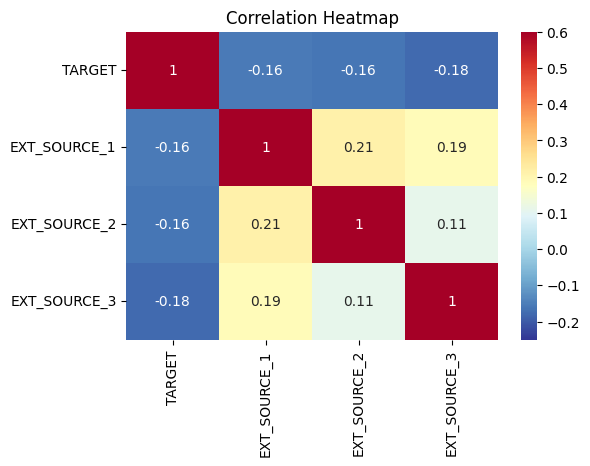

In [32]:
plt.figure(figsize = (6, 4))

# Heatmap of correlations
sns.heatmap(ext_data_corrs, cmap = plt.cm.RdYlBu_r, vmin = -0.25, annot = True, vmax = 0.6)
plt.title('Correlation Heatmap');

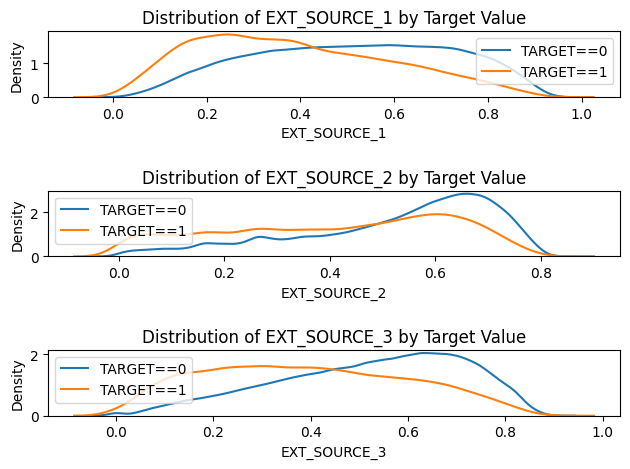

In [33]:
for i,source in enumerate(['EXT_SOURCE_1','EXT_SOURCE_2','EXT_SOURCE_3']):
    plt.subplot(3,1,i+1)
    sns.kdeplot(application_train.loc[application_train['TARGET']==0,source],label= "TARGET==0")
    sns.kdeplot(application_train.loc[application_train['TARGET']==1,source],label= "TARGET==1")
    plt.title('Distribution of %s by Target Value' % source)
    plt.xlabel('%s' % source)
    plt.ylabel('Density')
    plt.legend()
plt.tight_layout(h_pad = 2)


## Polynomial Features

In [34]:
#A new data frame for polynomial features
poly_features=application_train[['EXT_SOURCE_1','EXT_SOURCE_2','EXT_SOURCE_3','DAYS_BIRTH','TARGET']]
poly_features_test=application_test[['EXT_SOURCE_1','EXT_SOURCE_2','EXT_SOURCE_3','DAYS_BIRTH']]
poly_target = poly_features['TARGET']


In [35]:
#to handle missing values in poly features
from sklearn.impute import SimpleImputer
poly_features = poly_features.drop(columns = ['TARGET'])
imputer=SimpleImputer(strategy='median')
poly_features=imputer.fit_transform(poly_features)
poly_features_test=imputer.transform(poly_features_test)

In [36]:
from sklearn.preprocessing import PolynomialFeatures
poly_transformer=PolynomialFeatures(degree = 3)
poly_transformer.fit(poly_features)
poly_features=poly_transformer.transform(poly_features)
poly_features_test=poly_transformer.transform(poly_features_test)
print('poly_features_shape',poly_features.shape)

poly_features_shape (307510, 35)


In [37]:
#generated polynomial features
poly_transformer.get_feature_names_out(input_features = ['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH'])[:15]

array(['1', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH',
       'EXT_SOURCE_1^2', 'EXT_SOURCE_1 EXT_SOURCE_2',
       'EXT_SOURCE_1 EXT_SOURCE_3', 'EXT_SOURCE_1 DAYS_BIRTH',
       'EXT_SOURCE_2^2', 'EXT_SOURCE_2 EXT_SOURCE_3',
       'EXT_SOURCE_2 DAYS_BIRTH', 'EXT_SOURCE_3^2',
       'EXT_SOURCE_3 DAYS_BIRTH', 'DAYS_BIRTH^2'], dtype=object)

In [38]:
poly_features = pd.DataFrame(poly_features,columns = poly_transformer.get_feature_names_out(['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH']))
poly_features["TARGET"]=poly_target
#Correlation between pooly features and target value
poly_corrs=poly_features.corr()['TARGET'].sort_values()
print(poly_corrs.head(10))
print(poly_corrs.tail(5))

EXT_SOURCE_2 EXT_SOURCE_3                -0.007945
EXT_SOURCE_3                             -0.007648
EXT_SOURCE_1 EXT_SOURCE_2 EXT_SOURCE_3   -0.007507
EXT_SOURCE_3^2                           -0.007405
EXT_SOURCE_2 EXT_SOURCE_3^2              -0.007402
EXT_SOURCE_2 EXT_SOURCE_3 DAYS_BIRTH     -0.007116
EXT_SOURCE_1 EXT_SOURCE_3^2              -0.007115
EXT_SOURCE_3^2 DAYS_BIRTH                -0.006979
EXT_SOURCE_3^3                           -0.006940
EXT_SOURCE_2^2 EXT_SOURCE_3              -0.006810
Name: TARGET, dtype: float64
EXT_SOURCE_1     -0.001241
EXT_SOURCE_1^2   -0.000957
EXT_SOURCE_1^3   -0.000787
TARGET            1.000000
1                      NaN
Name: TARGET, dtype: float64


In [39]:
# Put test features into dataframe
poly_features_test = pd.DataFrame(poly_features_test, 
                                  columns = poly_transformer.get_feature_names_out(['EXT_SOURCE_1', 'EXT_SOURCE_2', 
                                                                                'EXT_SOURCE_3', 'DAYS_BIRTH']))

# Merge polynomial features into training dataframe
poly_features['SK_ID_CURR'] = application_train['SK_ID_CURR']
app_train_poly = application_train.merge(poly_features, on = 'SK_ID_CURR', how = 'left')

# Merge polnomial features into testing dataframe
poly_features_test['SK_ID_CURR'] = application_test['SK_ID_CURR']
app_test_poly = application_test.merge(poly_features_test, on = 'SK_ID_CURR', how = 'left')

# Align the dataframes
app_train_poly, app_test_poly = app_train_poly.align(app_test_poly, join = 'inner', axis = 1)

# Print out the new shapes
print('Training data with polynomial features shape: ', app_train_poly.shape)
print('Testing data with polynomial features shape:  ', app_test_poly.shape)

Training data with polynomial features shape:  (307510, 277)
Testing data with polynomial features shape:   (48744, 277)


## Domain Features

In [40]:
app_train_domain = application_train.copy()
app_test_domain = application_test.copy()

app_train_domain['CREDIT_INCOME_PERCENT'] = app_train_domain['AMT_CREDIT'] / app_train_domain['AMT_INCOME_TOTAL']
app_train_domain['ANNUITY_INCOME_PERCENT'] = app_train_domain['AMT_ANNUITY'] / app_train_domain['AMT_INCOME_TOTAL']
app_train_domain['CREDIT_TERM'] = app_train_domain['AMT_ANNUITY'] / app_train_domain['AMT_CREDIT']
app_train_domain['DAYS_EMPLOYED_PERCENT'] = app_train_domain['DAYS_EMPLOYED'] / app_train_domain['DAYS_BIRTH']


In [41]:
app_test_domain['CREDIT_INCOME_PERCENT'] = app_test_domain['AMT_CREDIT'] / app_test_domain['AMT_INCOME_TOTAL']
app_test_domain['ANNUITY_INCOME_PERCENT'] = app_test_domain['AMT_ANNUITY'] / app_test_domain['AMT_INCOME_TOTAL']
app_test_domain['CREDIT_TERM'] = app_test_domain['AMT_ANNUITY'] / app_test_domain['AMT_CREDIT']
app_test_domain['DAYS_EMPLOYED_PERCENT'] = app_test_domain['DAYS_EMPLOYED'] / app_test_domain['DAYS_BIRTH']


In [42]:
print(app_train_domain.shape)

(307510, 251)


In [43]:
domain_columns_train = app_train_domain.columns.difference(app_train_poly.columns)
domain_columns_test = app_test_domain.columns.difference(app_test_poly.columns)

# Now, concatenate the app_train_poly and the selected domain columns
app_train_combined = pd.concat([app_train_poly, app_train_domain[domain_columns_train]], axis=1)
app_test_combined = pd.concat([app_test_poly, app_test_domain[domain_columns_test]], axis=1)

# Align the dataframes
app_train_combined, app_test_combined = app_train_combined.align(app_test_combined, join = 'inner', axis = 1)
print(app_train_combined.shape)
print(app_test_combined.shape)

(307511, 285)
(48744, 285)


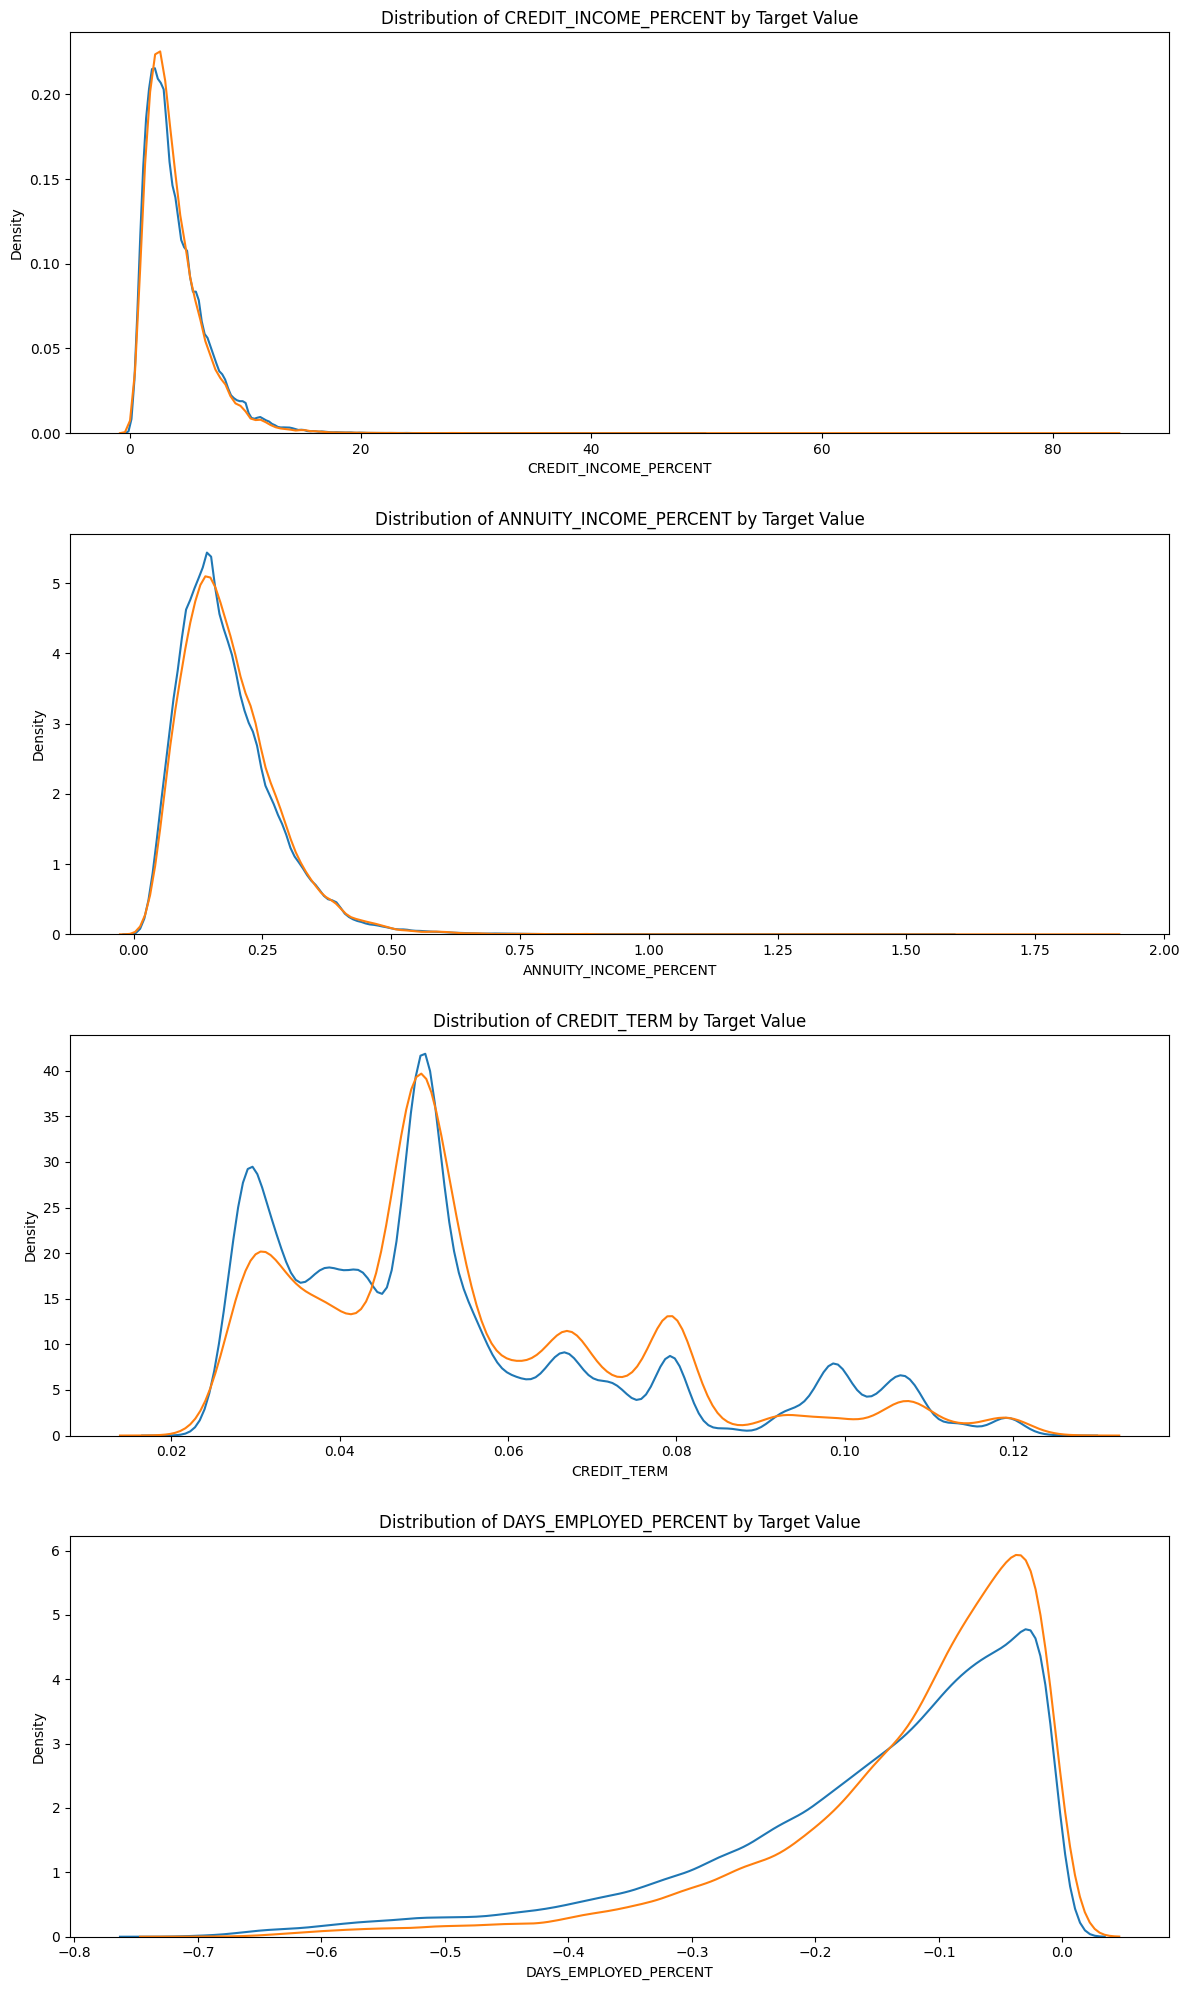

In [44]:
plt.figure(figsize = (12, 20))
for i, feature in enumerate(['CREDIT_INCOME_PERCENT', 'ANNUITY_INCOME_PERCENT', 'CREDIT_TERM', 'DAYS_EMPLOYED_PERCENT']):
    plt.subplot(4, 1, i + 1)
    sns.kdeplot(app_train_domain.loc[app_train_domain['TARGET'] == 0, feature], label = 'target == 0')
    sns.kdeplot(app_train_domain.loc[app_train_domain['TARGET'] == 1, feature], label = 'target == 1')
    plt.title('Distribution of %s by Target Value' % feature)
    plt.xlabel('%s' % feature); plt.ylabel('Density');
    
plt.tight_layout(h_pad=2.5)

In [45]:


def preprocess_data(train_data, test_data, target_col='TARGET'):
    """
    Preprocess the training and testing data.
    
    Steps:
    1. Drop the target column from training data (if it exists).
    2. Align training and testing data to have the same features.
    3. Impute missing values with the median.
    4. Scale features to the range [0, 1].
    
    Args:
    - train_data (pd.DataFrame): The training dataset, including the target column.
    - test_data (pd.DataFrame): The testing dataset.
    - target_col (str): The name of the target column in the training dataset. Default is 'TARGET'.
    
    Returns:
    - train (pd.DataFrame): Preprocessed training data.
    - test (pd.DataFrame): Preprocessed testing data.
    """
    # Drop the target column from the training data if it exists
    if target_col in train_data:
        train = train_data.drop(columns=[target_col])
    else:
        train = train_data.copy()

    # Create a copy of the test data
    test = test_data.copy()
    train=train.drop(columns=['SK_ID_CURR'])
    test=test.drop(columns=['SK_ID_CURR'])
    # Align the training and testing datasets
    train, test = train.align(test, join='inner', axis=1)

    # Initialize the imputer and scaler
    imputer = SimpleImputer(strategy='median')
    scaler = MinMaxScaler(feature_range=(0, 1))

    # Impute missing values and scale the features
    train = imputer.fit_transform(train)
    test = imputer.transform(test)
    train = scaler.fit_transform(train)
    test = scaler.transform(test)

    # Convert the processed data back to DataFrames with appropriate column names
    features = train_data.drop(columns=[target_col]).columns if target_col in train_data else train_data.columns
    train = pd.DataFrame(train, columns=features[:train.shape[1]])
    test = pd.DataFrame(test, columns=features[:test.shape[1]])

    #print initial data shapes
    print('Initial training data shape',train_data.shape)
    print('Initial testing data shape',test_data.shape)
    # Print data shapes
    print('Training data shape:', train.shape)
    print('Testing data shape:', test.shape)

    return train, test



In [46]:
app_train_base,app_test_base=preprocess_data(application_train,application_test)
app_train_poly,app_test_poly=preprocess_data(app_train_poly,app_test_poly)
app_train_comb,app_test_comb=preprocess_data(app_train_combined,app_test_combined)


Initial training data shape (307510, 247)
Initial testing data shape (48744, 242)
Training data shape: (307510, 241)
Testing data shape: (48744, 241)
Initial training data shape (307510, 277)
Initial testing data shape (48744, 277)
Training data shape: (307510, 276)
Testing data shape: (48744, 276)
Initial training data shape (307511, 285)
Initial testing data shape (48744, 285)
Training data shape: (307511, 284)
Testing data shape: (48744, 284)


In [47]:
app_train_comb = app_train_comb.drop(app_train_comb.index[-1])

In [48]:
app_train_comb.tail(5)

,SK_ID_CURR,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH_x,DAYS_EMPLOYED,DAYS_REGISTRATION,...,EXT_SOURCE_3^2 DAYS_BIRTH,EXT_SOURCE_3 DAYS_BIRTH^2,DAYS_BIRTH^3,ANNUITY_INCOME_PERCENT,CREDIT_INCOME_PERCENT,CREDIT_TERM,DAYS_BIRTH,DAYS_EMPLOYED_PERCENT,EXT_SOURCE_1,EXT_SOURCE_2
307505,0.0,0.007335,0.052360,0.101176,0.046016,0.446855,0.103608,0.986824,0.657263,0.724607,...,0.428362,0.546510,0.102886,0.023170,0.741790,0.952368,0.837086,0.518318,0.405136,0.828218
307506,0.0,0.002579,0.056067,0.040505,0.046016,0.344429,0.748929,0.907995,0.822147,0.431708,...,0.090846,0.187494,0.091656,0.018650,0.841421,0.103608,0.965282,0.138170,0.797231,0.597163
307507,0.0,0.007085,0.157969,0.110618,0.135802,0.065247,0.421477,0.557782,0.726937,0.284424,...,0.175314,0.082566,0.087232,0.043758,0.219346,0.748929,0.837086,0.518318,0.135663,0.597163
307508,0.0,0.008086,0.081175,0.072499,0.069585,0.069553,0.252086,0.732805,0.896158,0.870641,...,0.059966,0.279390,0.102854,0.051850,0.216557,0.421477,0.273795,0.769370,0.626575,0.243815
307509,0.0,0.007335,0.157303,0.185258,0.158249,0.635991,0.528016,0.929544,0.792153,0.943032,...,0.230090,0.222976,0.061317,0.025111,0.317709,0.252086,0.450978,0.518318,0.601360,0.737587


## Evaluation using Baseline Models

### Logistic regression

In [49]:
def logistic_regression_pipeline(train_data, test_data, target_col='TARGET', id_col='SK_ID_CURR'):
    """
    Train and evaluate a Logistic Regression model and generate predictions for the test dataset.
    
    The output file name is dynamically created based on the variable names of `train_data` and `test_data`.

    Args:
    - train_data (pd.DataFrame): Preprocessed training data with the target column.
    - test_data (pd.DataFrame): Preprocessed testing data without the target column.
    - target_col (str): The name of the target column in the training dataset. Default is 'TARGET'.
    - id_col (str): The name of the ID column in the testing dataset for submission. Default is 'SK_ID_CURR'.

    Returns:
    - None (Saves the submission file and prints evaluation metrics).
    """
    # Dynamically retrieve the variable names passed as arguments
    train_data_name = [name for name, val in inspect.currentframe().f_back.f_locals.items() if val is train_data][0]
    test_data_name = [name for name, val in inspect.currentframe().f_back.f_locals.items() if val is test_data][0]
    output_file = f"{train_data_name}_to_{test_data_name}_logistic_regression.csv"

    # Separate target variable
    target = application_train['TARGET']

    # Train-validation split
    X_train, X_valid, y_train, y_valid = train_test_split(
        train_data, target, test_size=0.2, random_state=42, stratify=target
    )

    # Logistic Regression Model
    logistic_model = LogisticRegression(
        max_iter=1000, random_state=42, class_weight='balanced'
    )
    logistic_model.fit(X_train, y_train)

    # Predictions and evaluation on the validation set
    y_valid_pred_lr = logistic_model.predict(X_valid)
    y_valid_prob_lr = logistic_model.predict_proba(X_valid)[:, 1]

    # Print evaluation metrics
    print("\n### Logistic Regression Metrics ###")
    print("ROC-AUC Score:", roc_auc_score(y_valid, y_valid_prob_lr))
    print("Accuracy:", accuracy_score(y_valid, y_valid_pred_lr))
    print("Precision:", precision_score(y_valid, y_valid_pred_lr))
    print("Recall:", recall_score(y_valid, y_valid_pred_lr))
    print("F1-Score:", f1_score(y_valid, y_valid_pred_lr))
    print("\nClassification Report:\n", classification_report(y_valid, y_valid_pred_lr))

    # Predict probabilities for the test dataset
    y_test_prob_lr = logistic_model.predict_proba(test_data)[:, 1]

    # Prepare the submission dataframe
    submission = test_data[[id_col]].copy()
    submission['TARGET'] = y_test_prob_lr

    # Save submission file
    submission.to_csv(output_file, index=False)
    print(f"\nSubmission file saved as: {output_file}")

    return submission



### For Base features

In [50]:
#logistic_regression_pipeline(app_train_base,app_test_base)

### For Poly features


In [51]:
#logistic_regression_pipeline(app_train_poly,app_test_poly)

### For Combined Features

In [52]:
#logistic_regression_pipeline(app_train_comb,app_test_comb)

### Random Forest

In [53]:
def random_forest_pipeline(train_data, test_data, target_col='TARGET', id_col='SK_ID_CURR'):
    """
    Train and evaluate a Random Forest model and generate predictions for the test dataset.
    
    The output file name is dynamically created based on the variable names of `train_data` and `test_data`.

    Args:
    - train_data (pd.DataFrame): Preprocessed training data with the target column.
    - test_data (pd.DataFrame): Preprocessed testing data without the target column.
    - target_col (str): The name of the target column in the training dataset. Default is 'TARGET'.
    - id_col (str): The name of the ID column in the testing dataset for submission. Default is 'SK_ID_CURR'.

    Returns:
    - None (Saves the submission file and prints evaluation metrics).
    """
    # Dynamically retrieve the variable names passed as arguments
    train_data_name = [name for name, val in inspect.currentframe().f_back.f_locals.items() if val is train_data][0]
    test_data_name = [name for name, val in inspect.currentframe().f_back.f_locals.items() if val is test_data][0]
    output_file = f"{train_data_name}_to_{test_data_name}_random_forest.csv"

    # Separate target variable
    target = application_train['TARGET']

    # Train-validation split
    X_train, X_valid, y_train, y_valid = train_test_split(
        train_data, target, test_size=0.2, random_state=42, stratify=target
    )

    # Random Forest Model
    rf_model = RandomForestClassifier(
        n_estimators=100, random_state=42, class_weight='balanced', n_jobs=-1
    )
    rf_model.fit(X_train, y_train)

    # Predictions and evaluation on the validation set
    y_valid_pred_rf = rf_model.predict(X_valid)
    y_valid_prob_rf = rf_model.predict_proba(X_valid)[:, 1]

    # Print evaluation metrics
    print("\n### Random Forest Metrics ###")
    print("ROC-AUC Score:", roc_auc_score(y_valid, y_valid_prob_rf))
    print("Accuracy:", accuracy_score(y_valid, y_valid_pred_rf))
    print("Precision:", precision_score(y_valid, y_valid_pred_rf))
    print("Recall:", recall_score(y_valid, y_valid_pred_rf))
    print("F1-Score:", f1_score(y_valid, y_valid_pred_rf))
    print("\nClassification Report:\n", classification_report(y_valid, y_valid_pred_rf))

    # Predict probabilities for the test dataset
    y_test_prob_rf = rf_model.predict_proba(test_data)[:, 1]

    # Prepare the submission dataframe
    submission = test_data[[id_col]].copy()
    submission['TARGET'] = y_test_prob_rf

    # Save submission file
    submission.to_csv(output_file, index=False)
    print(f"\nSubmission file saved as: {output_file}")

    ##Feature Importance
    # Get feature importance from the trained model
    feature_importance = rf_model.feature_importances_

    # Create a DataFrame to hold feature names and their importance
    feature_df = pd.DataFrame({
        'feature': X_train.columns,
        'importance': feature_importance
    })

    # Sort the features by importance in descending order
    feature_df = feature_df.sort_values(by='importance', ascending=False)
    top_n=10
    # Select the top N features
    top_features = feature_df.head(top_n)

    # Plot the top N most important features
    plt.figure(figsize=(10, 6))
    plt.barh(top_features['feature'], top_features['importance'], color='skyblue')
    plt.xlabel('Feature Importance')
    plt.title(f'Top {top_n} Important Features')
    plt.gca().invert_yaxis()  # To display the most important feature at the top
    plt.show()

    return submission

In [54]:
#random_forest_pipeline(app_train_comb,app_test_comb)

# Feature Engineering

## Handling Bureau and Bureau_balance datasets

In [55]:
# Aggregate function for numeric columns
def agg_numeric(df, group_var, df_name):
    """Aggregates the numeric values in a dataframe. This can
    be used to create features for each instance of the grouping variable.
    
    Parameters
    --------
        df (dataframe): 
            the dataframe to calculate the statistics on
        group_var (string): 
            the variable by which to group df
        df_name (string): 
            the variable used to rename the columns
        
    Return
    --------
        agg (dataframe): 
            a dataframe with the statistics aggregated for 
            all numeric columns. Each instance of the grouping variable will have 
            the statistics (mean, min, max, sum; currently supported) calculated. 
            The columns are also renamed to keep track of features created.
    
    """
    # Remove id variables other than grouping variable
    for col in df:
        if col != group_var and 'SK_ID' in col:
            df = df.drop(columns = col)
            
    group_ids = df[group_var]
    numeric_df = df.select_dtypes('number')
    numeric_df[group_var] = group_ids

    # Group by the specified variable and calculate the statistics
    agg = numeric_df.groupby(group_var).agg(['count', 'mean', 'max', 'min', 'sum']).reset_index()

    # Need to create new column names
    columns = [group_var]

    # Iterate through the variables names
    for var in agg.columns.levels[0]:
        # Skip the grouping variable
        if var != group_var and var!= 'index':
            # Iterate through the stat names
            for stat in agg.columns.levels[1][:-1]:
                # Make a new column name for the variable and stat
                columns.append('%s_%s_%s' % (df_name, var, stat))

    agg.columns = columns
    return agg


In [56]:
#aggregate function for categorical columns
def agg_categorical(df, parent_var, df_name):
    """
    Aggregates the categorical features in a child dataframe
    for each observation of the parent variable.
    
    Parameters
    --------
    df : dataframe 
        The dataframe to calculate the value counts for.
        
    parent_var : string
        The variable by which to group and aggregate the dataframe. For each unique
        value of this variable, the final dataframe will have one row
        
    df_name : string
        Variable added to the front of column names to keep track of columns

    
    Return
    --------
    categorical : dataframe
        A dataframe with aggregated statistics for each observation of the parent_var
        The columns are also renamed and columns with duplicate values are removed.
        
    """
    
    # Select the categorical columns
    categorical = pd.get_dummies(df.select_dtypes('category'))

    # Make sure to put the identifying id on the column
    categorical[parent_var] = df[parent_var]

    # Groupby the group var and calculate the sum and mean
    categorical = categorical.groupby(parent_var).agg(['sum', 'count', 'mean'])
    
    column_names = []
    
    # Iterate through the columns in level 0
    for var in categorical.columns.levels[0]:
        # Iterate through the stats in level 1
        for stat in ['sum', 'count', 'mean']:
            # Make a new column name
            column_names.append('%s_%s_%s' % (df_name, var, stat))
    
    categorical.columns = column_names
    
    # Remove duplicate columns by values
    _, idx = np.unique(categorical, axis = 1, return_index = True)
    categorical = categorical.iloc[:, idx]
    
    return categorical

In [57]:
# Function for categorical count
def count_categorical(df, group_var, df_name):
    """Computes counts and normalized counts for each observation
    of `group_var` of each unique category in every categorical variable
    
    Parameters
    --------
    df : dataframe 
        The dataframe to calculate the value counts for.
        
    group_var : string
        The variable by which to group the dataframe. For each unique
        value of this variable, the final dataframe will have one row
        
    df_name : string
        Variable added to the front of column names to keep track of columns

    
    Return
    --------
    categorical : dataframe
        A dataframe with counts and normalized counts of each unique category in every categorical variable
        with one row for every unique value of the `group_var`.
        
    """
    
    # Select the categorical columns
    categorical = pd.get_dummies(df.select_dtypes('object'))

    # Make sure to put the identifying id on the column
    categorical[group_var] = df[group_var]

    # Groupby the group var and calculate the sum and mean
    categorical = categorical.groupby(group_var).agg(['sum', 'mean'])
    
    column_names = []
    
    # Iterate through the columns in level 0
    for var in categorical.columns.levels[0]:
        # Iterate through the stats in level 1
        for stat in ['count', 'count_norm']:
            # Make a new column name
            column_names.append('%s_%s_%s' % (df_name, var, stat))
    
    categorical.columns = column_names
    
    return categorical

In [58]:
# Function to calculate correlations with the target for a dataframe
def target_corrs(df):

    # List of correlations
    corrs = []

    # Iterate through the columns 
    for col in df.columns:
        print(col)
        # Skip the target column
        if col != 'TARGET':
            # Calculate correlation with the target
            corr = df['TARGET'].corr(df[col])

            # Append the list as a tuple
            corrs.append((col, corr))
            
    # Sort by absolute magnitude of correlations
    corrs = sorted(corrs, key = lambda x: abs(x[1]), reverse = True)
    
    return corrs

In [59]:
bureau_counts = count_categorical(bureau, group_var = 'SK_ID_CURR', df_name = 'bureau')
bureau_balance_counts = count_categorical(bureau_balance, group_var = 'SK_ID_BUREAU', df_name = 'bureau_balance')


In [60]:
bureau_agg = agg_numeric(bureau.drop(columns = ['SK_ID_BUREAU']), group_var = 'SK_ID_CURR', df_name = 'bureau')
bureau_balance_agg = agg_numeric(bureau_balance, group_var = 'SK_ID_BUREAU', df_name = 'bureau_balance')

In [61]:
# Dataframe grouped by the loan
bureau_by_loan = bureau_balance_agg.merge(bureau_balance_counts, right_index = True, left_on = 'SK_ID_BUREAU', how = 'outer')

# Merge to include the SK_ID_CURR
bureau_by_loan = bureau[['SK_ID_BUREAU', 'SK_ID_CURR']].merge(bureau_by_loan, on = 'SK_ID_BUREAU', how = 'left')

# Aggregate the stats for each client
bureau_balance_by_client = agg_numeric(bureau_by_loan.drop(columns = ['SK_ID_BUREAU']), group_var = 'SK_ID_CURR', df_name = 'client')

In [62]:
application_train_1=pd.read_csv('/kaggle/input/home-credit-default-risk/application_train.csv')
application_test_1=pd.read_csv('/kaggle/input/home-credit-default-risk/application_test.csv')

In [63]:
application_train_1.shape

(307511, 122)

In [64]:
train=application_train_1
# Merge with the value counts of bureau
train = train.merge(bureau_counts, on = 'SK_ID_CURR', how = 'left')

# Merge with the stats of bureau
train = train.merge(bureau_agg, on = 'SK_ID_CURR', how = 'left')

# Merge with the monthly information grouped by client
train = train.merge(bureau_balance_by_client, on = 'SK_ID_CURR', how = 'left')
train.shape

(307511, 333)

In [65]:
# Read in the test dataframe
test = application_test_1
# Merge with the value counts of bureau
test = test.merge(bureau_counts, on = 'SK_ID_CURR', how = 'left')

# Merge with the stats of bureau
test = test.merge(bureau_agg, on = 'SK_ID_CURR', how = 'left')

# Merge with the value counts of bureau balance
test = test.merge(bureau_balance_by_client, on = 'SK_ID_CURR', how = 'left')
test.shape

(48744, 332)

In [66]:
# Calculate all correlations in dataframe
numerical_category = train.select_dtypes(include=['number']).columns.tolist()

corrs = train[numerical_category].corr()
corrs = corrs.sort_values('TARGET', ascending = False)


In [67]:
# Set the threshold
threshold = 0.8

# Empty dictionary to hold correlated variables
above_threshold_vars = {}

# For each column, record the variables that are above the threshold
for col in corrs:
    above_threshold_vars[col] = list(corrs.index[corrs[col] > threshold])

# Track columns to remove and columns already examined
cols_to_remove = []
cols_seen = []
cols_to_remove_pair = []

# Iterate through columns and correlated columns
for key, value in above_threshold_vars.items():
    # Keep track of columns already examined
    cols_seen.append(key)
    for x in value:
        if x == key:
            next
        else:
            # Only want to remove one in a pair
            if x not in cols_seen:
                cols_to_remove.append(x)
                cols_to_remove_pair.append(key)
            
cols_to_remove = list(set(cols_to_remove))
print('Number of columns to remove: ', len(cols_to_remove))

Number of columns to remove:  134


In [68]:
train_corrs_removed = train.drop(columns = cols_to_remove)
test_corrs_removed = test.drop(columns = cols_to_remove)
train_corrs_removed.to_csv('train_bureau_corrs_removed.csv', index = False)
test_corrs_removed.to_csv('test_bureau_corrs_removed.csv', index = False)

### Evaluation using Light GBM

In [69]:
def plot_feature_importances(df):
    """
    Plot importances returned by a model. This can work with any measure of
    feature importance provided that higher importance is better. 
    
    Args:
        df (dataframe): feature importances. Must have the features in a column
        called `features` and the importances in a column called `importance
        
    Returns:
        shows a plot of the 15 most importance features
        
        df (dataframe): feature importances sorted by importance (highest to lowest) 
        with a column for normalized importance
        """
    
    # Sort features according to importance
    df = df.sort_values('importance', ascending = False).reset_index()
    
    # Normalize the feature importances to add up to one
    df['importance_normalized'] = df['importance'] / df['importance'].sum()

    # Make a horizontal bar chart of feature importances
    plt.figure(figsize = (10, 6))
    ax = plt.subplot()
    
    # Need to reverse the index to plot most important on top
    ax.barh(list(reversed(list(df.index[:15]))), 
            df['importance_normalized'].head(15), 
            align = 'center', edgecolor = 'k')
    
    # Set the yticks and labels
    ax.set_yticks(list(reversed(list(df.index[:15]))))
    ax.set_yticklabels(df['feature'].head(15))
    
    # Plot labeling
    plt.xlabel('Normalized Importance'); plt.title('Feature Importances')
    plt.show()
    
    return df

In [70]:
#submission_corrs, fi_corrs, metrics_corr = model(train_corrs_removed, test_corrs_removed)

In [71]:
#metrics_corr

In [72]:
#fi_corrs_sorted = plot_feature_importances(fi_corrs)

In [73]:
#submission_corrs.to_csv('fe_1_corrs.csv', index = False)

## Handling Home Credit Datasets

In [74]:
# Plots the disribution of a variable colored by value of the target
def kde_target(var_name, df):
    
    # Calculate the correlation coefficient between the new variable and the target
    corr = df['TARGET'].corr(df[var_name])
    
    # Calculate medians for repaid vs not repaid
    avg_repaid = df.ix[df['TARGET'] == 0, var_name].median()
    avg_not_repaid = df.ix[df['TARGET'] == 1, var_name].median()
    
    plt.figure(figsize = (12, 6))
    
    # Plot the distribution for target == 0 and target == 1
    sns.kdeplot(df.ix[df['TARGET'] == 0, var_name], label = 'TARGET == 0')
    sns.kdeplot(df.ix[df['TARGET'] == 1, var_name], label = 'TARGET == 1')
    
    # label the plot
    plt.xlabel(var_name); plt.ylabel('Density'); plt.title('%s Distribution' % var_name)
    plt.legend();
    
    # print out the correlation
    print('The correlation between %s and the TARGET is %0.4f' % (var_name, corr))
    # Print out average values
    print('Median value for loan that was not repaid = %0.4f' % avg_not_repaid)
    print('Median value for loan that was repaid =     %0.4f' % avg_repaid)

In [75]:
# Function to Convert Data Types to reduce size

import sys

def return_size(df):
    """Return size of dataframe in gigabytes"""
    return round(sys.getsizeof(df) / 1e9, 2)

def convert_types(df, print_info = False):
    
    original_memory = df.memory_usage().sum()
    
    # Iterate through each column
    for c in df:
        
        # Convert ids and booleans to integers
        if ('SK_ID' in c):
            df[c] = df[c].fillna(0).astype(np.int32)
            
        # Convert objects to category
        elif (df[c].dtype == 'object') and (df[c].nunique() < df.shape[0]):
            df[c] = df[c].astype('category')
        
        # Booleans mapped to integers
        elif list(df[c].unique()) == [1, 0]:
            df[c] = df[c].astype(bool)
        
        # Float64 to float32
        elif df[c].dtype == float:
            df[c] = df[c].astype(np.float32)
            
        # Int64 to int32
        elif df[c].dtype == int:
            df[c] = df[c].astype(np.int32)
        
    new_memory = df.memory_usage().sum()
    
    if print_info:
        print(f'Original Memory Usage: {round(original_memory / 1e9, 2)} gb.')
        print(f'New Memory Usage: {round(new_memory / 1e9, 2)} gb.')
        
    return df

In [76]:
previous = previous_application
previous = convert_types(previous, print_info=True)
previous.head()

Original Memory Usage: 0.49 gb.
New Memory Usage: 0.16 gb.


,SK_ID_PREV,SK_ID_CURR,NAME_CONTRACT_TYPE,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,...,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
0,2030495,271877,Consumer loans,1730.430054,17145.0,17145.0,0.0,17145.0,SATURDAY,15,...,Connectivity,12.0,middle,POS mobile with interest,365243.0,-42.0,300.0,-42.0,-37.0,0.0
1,2802425,108129,Cash loans,25188.615234,607500.0,679671.0,NaN,607500.0,THURSDAY,11,...,XNA,36.0,low_action,Cash X-Sell: low,365243.0,-134.0,916.0,365243.0,365243.0,1.0
2,2523466,122040,Cash loans,15060.735352,112500.0,136444.5,NaN,112500.0,TUESDAY,11,...,XNA,12.0,high,Cash X-Sell: high,365243.0,-271.0,59.0,365243.0,365243.0,1.0
3,2819243,176158,Cash loans,47041.335938,450000.0,470790.0,NaN,450000.0,MONDAY,7,...,XNA,12.0,middle,Cash X-Sell: middle,365243.0,-482.0,-152.0,-182.0,-177.0,1.0
4,1784265,202054,Cash loans,31924.394531,337500.0,404055.0,NaN,337500.0,THURSDAY,9,...,XNA,24.0,high,Cash Street: high,NaN,NaN,NaN,NaN,NaN,NaN


In [77]:
# Calculate aggregate statistics for each numeric column
previous_agg = agg_numeric(previous, 'SK_ID_CURR', 'previous')
print('Previous aggregation shape: ', previous_agg.shape)
previous_agg.head()

Previous aggregation shape:  (338857, 91)


,SK_ID_CURR,previous_AMT_ANNUITY_count,previous_AMT_ANNUITY_mean,previous_AMT_ANNUITY_max,previous_AMT_ANNUITY_min,previous_AMT_ANNUITY_sum,previous_AMT_APPLICATION_count,previous_AMT_APPLICATION_mean,previous_AMT_APPLICATION_max,previous_AMT_APPLICATION_min,...,previous_DAYS_TERMINATION_count,previous_DAYS_TERMINATION_mean,previous_DAYS_TERMINATION_max,previous_DAYS_TERMINATION_min,previous_DAYS_TERMINATION_sum,previous_NFLAG_INSURED_ON_APPROVAL_count,previous_NFLAG_INSURED_ON_APPROVAL_mean,previous_NFLAG_INSURED_ON_APPROVAL_max,previous_NFLAG_INSURED_ON_APPROVAL_min,previous_NFLAG_INSURED_ON_APPROVAL_sum
0,100001,1,3951.000000,3951.000000,3951.000000,3951.000000,1,24835.50,24835.5,24835.5,...,1,-1612.000000,-1612.0,-1612.0,-1612.0,1,0.000000,0.0,0.0,0.0
1,100002,1,9251.775391,9251.775391,9251.775391,9251.775391,1,179055.00,179055.0,179055.0,...,1,-17.000000,-17.0,-17.0,-17.0,1,0.000000,0.0,0.0,0.0
2,100003,3,56553.988281,98356.992188,6737.310059,169661.968750,3,435436.50,900000.0,68809.5,...,3,-1047.333374,-527.0,-1976.0,-3142.0,3,0.666667,1.0,0.0,2.0
3,100004,1,5357.250000,5357.250000,5357.250000,5357.250000,1,24282.00,24282.0,24282.0,...,1,-714.000000,-714.0,-714.0,-714.0,1,0.000000,0.0,0.0,0.0
4,100005,1,4813.200195,4813.200195,4813.200195,4813.200195,2,22308.75,44617.5,0.0,...,1,-460.000000,-460.0,-460.0,-460.0,1,0.000000,0.0,0.0,0.0


In [78]:
# Calculate value counts for each categorical column
previous_counts = agg_categorical(previous, 'SK_ID_CURR', 'previous')
print('Previous counts shape: ', previous_counts.shape)
previous_counts.head()

Previous counts shape:  (338857, 285)


,previous_NAME_GOODS_CATEGORY_Animals_mean,previous_NAME_GOODS_CATEGORY_Animals_sum,previous_NAME_GOODS_CATEGORY_House Construction_mean,previous_NAME_GOODS_CATEGORY_House Construction_sum,previous_NAME_CASH_LOAN_PURPOSE_Refusal to name the goal_mean,previous_NAME_CASH_LOAN_PURPOSE_Refusal to name the goal_sum,previous_NAME_CASH_LOAN_PURPOSE_Money for a third person_mean,previous_NAME_CASH_LOAN_PURPOSE_Money for a third person_sum,previous_NAME_CASH_LOAN_PURPOSE_Hobby_mean,previous_NAME_CASH_LOAN_PURPOSE_Hobby_sum,...,previous_CODE_REJECT_REASON_XAP_mean,previous_FLAG_LAST_APPL_PER_CONTRACT_Y_mean,previous_NAME_PORTFOLIO_POS_sum,previous_NAME_CONTRACT_TYPE_Consumer loans_sum,previous_NAME_CASH_LOAN_PURPOSE_XAP_sum,previous_NAME_PRODUCT_TYPE_XNA_sum,previous_NAME_CONTRACT_STATUS_Approved_sum,previous_CODE_REJECT_REASON_XAP_sum,previous_FLAG_LAST_APPL_PER_CONTRACT_Y_sum,previous_NAME_CONTRACT_TYPE_Cash loans_count
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
100001,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,...,1.0,1.0,1,1,1,1,1,1,1,1
100002,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,...,1.0,1.0,1,1,1,1,1,1,1,1
100003,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,...,1.0,1.0,2,2,2,2,3,3,3,3
100004,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,...,1.0,1.0,1,1,1,1,1,1,1,1
100005,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,...,1.0,1.0,1,1,1,2,1,2,2,2


In [79]:
application_train_2=pd.read_csv('/kaggle/input/home-credit-default-risk/application_train.csv')
application_test_2=pd.read_csv('/kaggle/input/home-credit-default-risk/application_test.csv')

In [80]:
train_2 = application_train_2
train_2 = convert_types(train_2)
test_2 = application_test_2
test_2 = convert_types(test_2)

# Merge in the previous information
train_2 = train_2.merge(previous_counts, on ='SK_ID_CURR', how = 'left')
train_2 = train_2.merge(previous_agg, on = 'SK_ID_CURR', how = 'left')

test_2 = test_2.merge(previous_counts, on ='SK_ID_CURR', how = 'left')
test_2 = test_2.merge(previous_agg, on = 'SK_ID_CURR', how = 'left')

# Remove variables to free memory
gc.enable()
del previous, previous_agg, previous_counts
gc.collect()


30588

In [81]:
print(train_2.shape)
print(test_2.shape)

(307511, 497)
(48744, 496)


In [82]:
# Function to calculate missing values by column# Funct 
def missing_values_table(df, print_info = False):
        # Total missing values
        mis_val = df.isnull().sum()
        
        # Percentage of missing values
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        
        # Make a table with the results
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
        # Rename the columns
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        
        # Sort the table by percentage of missing descending
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        
        if print_info:
            # Print some summary information
            print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
                "There are " + str(mis_val_table_ren_columns.shape[0]) +
                  " columns that have missing values.")
        
        # Return the dataframe with missing information
        return mis_val_table_ren_columns

In [83]:
def remove_missing_columns(train, test, threshold = 90):
    # Calculate missing stats for train and test (remember to calculate a percent!)
    train_miss = pd.DataFrame(train.isnull().sum())
    train_miss['percent'] = 100 * train_miss[0] / len(train)
    
    test_miss = pd.DataFrame(test.isnull().sum())
    test_miss['percent'] = 100 * test_miss[0] / len(test)
    
    # list of missing columns for train and test
    missing_train_columns = list(train_miss.index[train_miss['percent'] > threshold])
    missing_test_columns = list(test_miss.index[test_miss['percent'] > threshold])
    
    # Combine the two lists together
    missing_columns = list(set(missing_train_columns + missing_test_columns))
    
    # Print information
    print('There are %d columns with greater than %d%% missing values.' % (len(missing_columns), threshold))
    
    # Drop the missing columns and return
    train = train.drop(columns = missing_columns)
    test = test.drop(columns = missing_columns)
    
    return train, test

In [84]:
train_2, test_2 = remove_missing_columns(train_2, test_2)

There are 6 columns with greater than 90% missing values.


In [85]:
def aggregate_client(df, group_vars, df_names):
    """Aggregate a dataframe with data at the loan level 
    at the client level
    
    Args:
        df (dataframe): data at the loan level
        group_vars (list of two strings): grouping variables for the loan 
        and then the client (example ['SK_ID_PREV', 'SK_ID_CURR'])
        names (list of two strings): names to call the resulting columns
        (example ['cash', 'client'])
        
    Returns:
        df_client (dataframe): aggregated numeric stats at the client level. 
        Each client will have a single row with all the numeric data aggregated
    """
    
    # Aggregate the numeric columns
    df_agg = agg_numeric(df, group_var = group_vars[0], df_name = df_names[0])
    
    # If there are categorical variables
    if any(df.dtypes == 'category'):
    
        # Count the categorical columns
        df_counts = agg_categorical(df, parent_var = group_vars[0], df_name = df_names[0])

        # Merge the numeric and categorical
        df_by_loan = df_counts.merge(df_agg, on = group_vars[0], how = 'outer')

        gc.enable()
        del df_agg, df_counts
        gc.collect()

        # Merge to get the client id in dataframe
        df_by_loan = df_by_loan.merge(df[[group_vars[0], group_vars[1]]], on = group_vars[0], how = 'left')

        # Remove the loan id
        df_by_loan = df_by_loan.drop(columns = [group_vars[0]])

        # Aggregate numeric stats by column
        df_by_client = agg_numeric(df_by_loan, group_var = group_vars[1], df_name = df_names[1])

        
    # No categorical variables
    else:
        # Merge to get the client id in dataframe
        df_by_loan = df_agg.merge(df[[group_vars[0], group_vars[1]]], on = group_vars[0], how = 'left')
        
        gc.enable()
        del df_agg
        gc.collect()
        
        # Remove the loan id
        df_by_loan = df_by_loan.drop(columns = [group_vars[0]])
        
        # Aggregate numeric stats by column
        df_by_client = agg_numeric(df_by_loan, group_var = group_vars[1], df_name = df_names[1])
        
    # Memory management
    gc.enable()
    del df, df_by_loan
    gc.collect()

    return df_by_client

In [86]:
cash = POS_CASH_balance
cash = convert_types(cash, print_info=True)
cash.head(5)
print(cash.shape)

Original Memory Usage: 0.64 gb.
New Memory Usage: 0.29 gb.
(10001358, 8)


In [87]:
cash_by_client = aggregate_client(cash, group_vars = ['SK_ID_PREV', 'SK_ID_CURR'], df_names = ['cash', 'client'])
cash_by_client.head()


,SK_ID_CURR,client_cash_NAME_CONTRACT_STATUS_XNA_mean_count,client_cash_NAME_CONTRACT_STATUS_XNA_mean_mean,client_cash_NAME_CONTRACT_STATUS_XNA_mean_max,client_cash_NAME_CONTRACT_STATUS_XNA_mean_min,client_cash_NAME_CONTRACT_STATUS_XNA_mean_sum,client_cash_NAME_CONTRACT_STATUS_XNA_sum_count,client_cash_NAME_CONTRACT_STATUS_XNA_sum_mean,client_cash_NAME_CONTRACT_STATUS_XNA_sum_max,client_cash_NAME_CONTRACT_STATUS_XNA_sum_min,...,client_cash_SK_DPD_DEF_min_count,client_cash_SK_DPD_DEF_min_mean,client_cash_SK_DPD_DEF_min_max,client_cash_SK_DPD_DEF_min_min,client_cash_SK_DPD_DEF_min_sum,client_cash_SK_DPD_DEF_sum_count,client_cash_SK_DPD_DEF_sum_mean,client_cash_SK_DPD_DEF_sum_max,client_cash_SK_DPD_DEF_sum_min,client_cash_SK_DPD_DEF_sum_sum
0,100001,9,0.0,0.0,0.0,0.0,9,0.0,0,0,...,9,0.0,0,0,0,9,3.111111,7,0,28
1,100002,19,0.0,0.0,0.0,0.0,19,0.0,0,0,...,19,0.0,0,0,0,19,0.000000,0,0,0
2,100003,28,0.0,0.0,0.0,0.0,28,0.0,0,0,...,28,0.0,0,0,0,28,0.000000,0,0,0
3,100004,4,0.0,0.0,0.0,0.0,4,0.0,0,0,...,4,0.0,0,0,0,4,0.000000,0,0,0
4,100005,11,0.0,0.0,0.0,0.0,11,0.0,0,0,...,11,0.0,0,0,0,11,0.000000,0,0,0


In [88]:
print('Cash by Client Shape: ', cash_by_client.shape)
train_2 = train_2.merge(cash_by_client, on = 'SK_ID_CURR', how = 'left')
test_2 = test_2.merge(cash_by_client, on = 'SK_ID_CURR', how = 'left')

gc.enable()
del cash, cash_by_client
gc.collect()

Cash by Client Shape:  (337252, 221)


0

In [89]:
train_2, test_2 = remove_missing_columns(train, test)

There are 0 columns with greater than 90% missing values.


In [90]:
credit = credit_card_balance
credit = convert_types(credit, print_info = True)
credit.head()

Original Memory Usage: 0.71 gb.
New Memory Usage: 0.34 gb.


,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT,AMT_DRAWINGS_POS_CURRENT,AMT_INST_MIN_REGULARITY,...,AMT_RECIVABLE,AMT_TOTAL_RECEIVABLE,CNT_DRAWINGS_ATM_CURRENT,CNT_DRAWINGS_CURRENT,CNT_DRAWINGS_OTHER_CURRENT,CNT_DRAWINGS_POS_CURRENT,CNT_INSTALMENT_MATURE_CUM,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,2562384,378907,-6,56.970001,135000,0.0,877.5,0.0,877.5,1700.324951,...,0.000000,0.000000,0.0,1,0.0,1.0,35.0,Active,0,0
1,2582071,363914,-1,63975.554688,45000,2250.0,2250.0,0.0,0.0,2250.000000,...,64875.554688,64875.554688,1.0,1,0.0,0.0,69.0,Active,0,0
2,1740877,371185,-7,31815.224609,450000,0.0,0.0,0.0,0.0,2250.000000,...,31460.085938,31460.085938,0.0,0,0.0,0.0,30.0,Active,0,0
3,1389973,337855,-4,236572.109375,225000,2250.0,2250.0,0.0,0.0,11795.759766,...,233048.968750,233048.968750,1.0,1,0.0,0.0,10.0,Active,0,0
4,1891521,126868,-1,453919.468750,450000,0.0,11547.0,0.0,11547.0,22924.890625,...,453919.468750,453919.468750,0.0,1,0.0,1.0,101.0,Active,0,0


In [91]:
credit_by_client = aggregate_client(credit, group_vars = ['SK_ID_PREV', 'SK_ID_CURR'], df_names = ['credit', 'client'])
credit_by_client.head()


,SK_ID_CURR,client_credit_NAME_CONTRACT_STATUS_Approved_mean_count,client_credit_NAME_CONTRACT_STATUS_Approved_mean_mean,client_credit_NAME_CONTRACT_STATUS_Approved_mean_max,client_credit_NAME_CONTRACT_STATUS_Approved_mean_min,client_credit_NAME_CONTRACT_STATUS_Approved_mean_sum,client_credit_NAME_CONTRACT_STATUS_Approved_sum_count,client_credit_NAME_CONTRACT_STATUS_Approved_sum_mean,client_credit_NAME_CONTRACT_STATUS_Approved_sum_max,client_credit_NAME_CONTRACT_STATUS_Approved_sum_min,...,client_credit_SK_DPD_DEF_min_count,client_credit_SK_DPD_DEF_min_mean,client_credit_SK_DPD_DEF_min_max,client_credit_SK_DPD_DEF_min_min,client_credit_SK_DPD_DEF_min_sum,client_credit_SK_DPD_DEF_sum_count,client_credit_SK_DPD_DEF_sum_mean,client_credit_SK_DPD_DEF_sum_max,client_credit_SK_DPD_DEF_sum_min,client_credit_SK_DPD_DEF_sum_sum
0,100006,6,0.0,0.0,0.0,0.0,6,0.0,0,0,...,6,0.0,0,0,0,6,0.0,0,0,0
1,100011,74,0.0,0.0,0.0,0.0,74,0.0,0,0,...,74,0.0,0,0,0,74,0.0,0,0,0
2,100013,96,0.0,0.0,0.0,0.0,96,0.0,0,0,...,96,0.0,0,0,0,96,1.0,1,1,96
3,100021,17,0.0,0.0,0.0,0.0,17,0.0,0,0,...,17,0.0,0,0,0,17,0.0,0,0,0
4,100023,8,0.0,0.0,0.0,0.0,8,0.0,0,0,...,8,0.0,0,0,0,8,0.0,0,0,0


In [92]:
print('Credit by client shape: ', credit_by_client.shape)

train_2 = train_2.merge(credit_by_client, on = 'SK_ID_CURR', how = 'left')
test_2 = test_2.merge(credit_by_client, on = 'SK_ID_CURR', how = 'left')

gc.enable()
del credit, credit_by_client
gc.collect()

Credit by client shape:  (103558, 576)


0

In [93]:
train_2, test_2 = remove_missing_columns(train, test)

There are 0 columns with greater than 90% missing values.


In [94]:
installments = installments_payments
installments = convert_types(installments, print_info = True)
installments.head()


Original Memory Usage: 0.87 gb.
New Memory Usage: 0.44 gb.


,SK_ID_PREV,SK_ID_CURR,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT
0,1054186,161674,1.0,6,-1180.0,-1187.0,6948.359863,6948.359863
1,1330831,151639,0.0,34,-2156.0,-2156.0,1716.525024,1716.525024
2,2085231,193053,2.0,1,-63.0,-63.0,25425.000000,25425.000000
3,2452527,199697,1.0,3,-2418.0,-2426.0,24350.130859,24350.130859
4,2714724,167756,1.0,2,-1383.0,-1366.0,2165.040039,2160.584961


In [95]:
installments_by_client = aggregate_client(installments, group_vars = ['SK_ID_PREV', 'SK_ID_CURR'], df_names = ['installments', 'client'])
installments_by_client.head()


,SK_ID_CURR,client_installments_NUM_INSTALMENT_VERSION_count_count,client_installments_NUM_INSTALMENT_VERSION_count_mean,client_installments_NUM_INSTALMENT_VERSION_count_max,client_installments_NUM_INSTALMENT_VERSION_count_min,client_installments_NUM_INSTALMENT_VERSION_count_sum,client_installments_NUM_INSTALMENT_VERSION_mean_count,client_installments_NUM_INSTALMENT_VERSION_mean_mean,client_installments_NUM_INSTALMENT_VERSION_mean_max,client_installments_NUM_INSTALMENT_VERSION_mean_min,...,client_installments_AMT_PAYMENT_min_count,client_installments_AMT_PAYMENT_min_mean,client_installments_AMT_PAYMENT_min_max,client_installments_AMT_PAYMENT_min_min,client_installments_AMT_PAYMENT_min_sum,client_installments_AMT_PAYMENT_sum_count,client_installments_AMT_PAYMENT_sum_mean,client_installments_AMT_PAYMENT_sum_max,client_installments_AMT_PAYMENT_sum_min,client_installments_AMT_PAYMENT_sum_sum
0,100001,7,3.571429,4,3,25,7,1.142857,1.250000,1.000000,...,7,3963.824951,3980.925049,3951.000000,2.774678e+04,7,21834.095703,2.925090e+04,11945.025391,1.528387e+05
1,100002,19,19.000000,19,19,361,19,1.052632,1.052632,1.052632,...,19,9251.775391,9251.775391,9251.775391,1.757837e+05,19,219625.703125,2.196257e+05,219625.703125,4.172888e+06
2,100003,25,9.160000,12,6,229,25,1.040000,1.142857,1.000000,...,25,46164.328125,98356.992188,6662.970215,1.154108e+06,25,453952.250000,1.150977e+06,80773.382812,1.134881e+07
3,100004,3,3.000000,3,3,9,3,1.333333,1.333333,1.333333,...,3,5357.250000,5357.250000,5357.250000,1.607175e+04,3,21288.464844,2.128846e+04,21288.464844,6.386539e+04
4,100005,9,9.000000,9,9,81,9,1.111111,1.111111,1.111111,...,9,4813.200195,4813.200195,4813.200195,4.331880e+04,9,56161.843750,5.616184e+04,56161.843750,5.054566e+05


In [96]:
print('Installments by client shape: ', installments_by_client.shape)

train_2 = train_2.merge(installments_by_client, on = 'SK_ID_CURR', how = 'left')
test_2 = test_2.merge(installments_by_client, on = 'SK_ID_CURR', how = 'left')

gc.enable()
del installments, installments_by_client
gc.collect()

Installments by client shape:  (339587, 151)


0

In [97]:
train_2, test_2 = remove_missing_columns(train, test)

There are 0 columns with greater than 90% missing values.


In [98]:
print('Final Training Shape: ', train_2.shape)
print('Final Testing Shape: ', test_2.shape)


Final Training Shape:  (307511, 333)
Final Testing Shape:  (48744, 332)


In [99]:
print(f'Final training size: {return_size(train_2)}')
print(f'Final testing size: {return_size(test_2)}')

Final training size: 1.08
Final testing size: 0.17


In [100]:
# train_2.to_csv('train_previous_raw.csv', index = False, chunksize = 500)
# test_2.to_csv('test_previous_raw.csv', index = False)

In [103]:
train_bureau = pd.read_csv('/kaggle/input/akhil-home-dataset/pre_dataset/pre_dataset/train_bureau_raw.csv', nrows = 1000)
test_bureau = pd.read_csv('/kaggle/input/akhil-home-dataset/pre_dataset/pre_dataset/test_bureau_raw.csv', nrows=1000)

train_previous = pd.read_csv('/kaggle/input/akhil-home-dataset/pre_dataset/pre_dataset/train_previous_raw.csv', nrows = 1000)
test_previous = pd.read_csv('/kaggle/input/akhil-home-dataset/pre_dataset/pre_dataset/test_previous_raw.csv', nrows = 1000)


In [104]:
# All columns in dataframes
bureau_columns = list(train_bureau.columns)
previous_columns = list(train_previous.columns)

In [105]:
# Bureau only features
bureau_features = list(set(bureau_columns) - set(previous_columns))

# Previous only features
previous_features = list(set(previous_columns) - set(bureau_columns))

# Original features will be in both datasets
original_features = list(set(previous_columns) & set(bureau_columns))

print('There are %d original features.' % len(original_features))
print('There are %d bureau and bureau balance features.' % len(bureau_features))
print('There are %d previous Home Credit loan features.' % len(previous_features))

There are 123 original features.
There are 179 bureau and bureau balance features.
There are 1043 previous Home Credit loan features.


In [106]:
train_labels = train_bureau['TARGET']
previous_features.append('SK_ID_CURR')

train_ids = train_bureau['SK_ID_CURR']
test_ids = test_bureau['SK_ID_CURR']

# Merge the dataframes avoiding duplicating columns by subsetting train_previous
train = train_bureau.merge(train_previous[previous_features], on = 'SK_ID_CURR')
test = test_bureau.merge(test_previous[previous_features], on = 'SK_ID_CURR')

print('Training shape: ', train.shape)
print('Testing shape: ', test.shape)

Training shape:  (1000, 1345)
Testing shape:  (1000, 1344)


In [107]:
# One hot encoding
train = pd.get_dummies(train)
test = pd.get_dummies(test)

# Match the columns in the dataframes
train, test = train.align(test, join = 'inner', axis = 1)
print('Training shape: ', train.shape)
print('Testing shape: ', test.shape)

Training shape:  (1000, 1447)
Testing shape:  (1000, 1447)


In [108]:
cols_with_id = [x for x in train.columns if 'SK_ID_CURR' in x]
cols_with_bureau_id = [x for x in train.columns if 'SK_ID_BUREAU' in x]
cols_with_previous_id = [x for x in train.columns if 'SK_ID_PREV' in x]
print('There are %d columns that contain SK_ID_CURR' % len(cols_with_id))
print('There are %d columns that contain SK_ID_BUREAU' % len(cols_with_bureau_id))
print('There are %d columns that contain SK_ID_PREV' % len(cols_with_previous_id))

train = train.drop(columns = cols_with_id)
test = test.drop(columns = cols_with_id)
print('Training shape: ', train.shape)
print('Testing shape: ', test.shape)


There are 49 columns that contain SK_ID_CURR
There are 0 columns that contain SK_ID_BUREAU
There are 0 columns that contain SK_ID_PREV
Training shape:  (1000, 1398)
Testing shape:  (1000, 1398)


## Remove collinear features

In [109]:

threshold = 0.9


corr_matrix = train.corr().abs()
corr_matrix.head()

,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,...,HOUSETYPE_MODE_terraced house,WALLSMATERIAL_MODE_Block,WALLSMATERIAL_MODE_Mixed,WALLSMATERIAL_MODE_Monolithic,WALLSMATERIAL_MODE_Others,WALLSMATERIAL_MODE_Panel,"WALLSMATERIAL_MODE_Stone, brick",WALLSMATERIAL_MODE_Wooden,EMERGENCYSTATE_MODE_No,EMERGENCYSTATE_MODE_Yes
CNT_CHILDREN,1.000000,0.055960,0.036836,0.055732,0.035851,0.060210,0.303782,0.218535,0.211766,0.036960,...,0.096914,0.064817,0.024544,0.019465,0.005586,0.030986,0.001443,0.027967,0.004500,0.020465
AMT_INCOME_TOTAL,0.055960,1.000000,0.429317,0.491143,0.439981,0.184339,0.088743,0.208663,0.130682,0.045634,...,0.033574,0.064520,0.020186,0.058210,0.060465,0.080291,0.000218,0.043426,0.107476,0.030645
AMT_CREDIT,0.036836,0.429317,1.000000,0.797209,0.986046,0.074287,0.065100,0.116515,0.027876,0.022994,...,0.005136,0.011202,0.007313,0.060005,0.009795,0.098314,0.018123,0.009507,0.075595,0.009483
AMT_ANNUITY,0.055732,0.491143,0.797209,1.000000,0.799121,0.106685,0.019480,0.139220,0.059163,0.024020,...,0.011107,0.022890,0.017907,0.084270,0.022107,0.133969,0.036801,0.032497,0.098291,0.036308
AMT_GOODS_PRICE,0.035851,0.439981,0.986046,0.799121,1.000000,0.073531,0.058535,0.115613,0.034500,0.030878,...,0.002397,0.020737,0.000716,0.069845,0.014077,0.094081,0.012866,0.019114,0.082543,0.000395


In [110]:
# Upper triangle of correlations
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool_))
upper.head()

,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,...,HOUSETYPE_MODE_terraced house,WALLSMATERIAL_MODE_Block,WALLSMATERIAL_MODE_Mixed,WALLSMATERIAL_MODE_Monolithic,WALLSMATERIAL_MODE_Others,WALLSMATERIAL_MODE_Panel,"WALLSMATERIAL_MODE_Stone, brick",WALLSMATERIAL_MODE_Wooden,EMERGENCYSTATE_MODE_No,EMERGENCYSTATE_MODE_Yes
CNT_CHILDREN,NaN,0.05596,0.036836,0.055732,0.035851,0.060210,0.303782,0.218535,0.211766,0.036960,...,0.096914,0.064817,0.024544,0.019465,0.005586,0.030986,0.001443,0.027967,0.004500,0.020465
AMT_INCOME_TOTAL,NaN,NaN,0.429317,0.491143,0.439981,0.184339,0.088743,0.208663,0.130682,0.045634,...,0.033574,0.064520,0.020186,0.058210,0.060465,0.080291,0.000218,0.043426,0.107476,0.030645
AMT_CREDIT,NaN,NaN,NaN,0.797209,0.986046,0.074287,0.065100,0.116515,0.027876,0.022994,...,0.005136,0.011202,0.007313,0.060005,0.009795,0.098314,0.018123,0.009507,0.075595,0.009483
AMT_ANNUITY,NaN,NaN,NaN,NaN,0.799121,0.106685,0.019480,0.139220,0.059163,0.024020,...,0.011107,0.022890,0.017907,0.084270,0.022107,0.133969,0.036801,0.032497,0.098291,0.036308
AMT_GOODS_PRICE,NaN,NaN,NaN,NaN,NaN,0.073531,0.058535,0.115613,0.034500,0.030878,...,0.002397,0.020737,0.000716,0.069845,0.014077,0.094081,0.012866,0.019114,0.082543,0.000395


In [111]:

to_drop = [column for column in upper.columns if any(upper[column] > threshold)]

print('There are %d columns to remove.' % (len(to_drop)))

There are 584 columns to remove.


In [112]:
train = train.drop(columns = to_drop)
test = test.drop(columns = to_drop)

print('Training shape: ', train.shape)
print('Testing shape: ', test.shape)

Training shape:  (1000, 814)
Testing shape:  (1000, 814)


Apply the same to entire dataset and store as train_combined and test_combined

In [113]:
train_combined=pd.read_csv('/kaggle/input/akhil-home-dataset/akhil_home_dataset/akhil_home_dataset/m_train_combined.csv')
test_combined=pd.read_csv('/kaggle/input/akhil-home-dataset/akhil_home_dataset/akhil_home_dataset/m_test_combined.csv')

In [114]:
print(train_combined.isnull().sum())
print(test_combined.isnull().sum())

CNT_CHILDREN                        0
AMT_INCOME_TOTAL                    0
AMT_CREDIT                          0
AMT_ANNUITY                        12
REGION_POPULATION_RELATIVE          0
                                   ..
WALLSMATERIAL_MODE_Stone, brick     0
WALLSMATERIAL_MODE_Wooden           0
EMERGENCYSTATE_MODE_Yes             0
SK_ID_CURR                          0
TARGET                              0
Length: 865, dtype: int64
SK_ID_CURR                          0
CNT_CHILDREN                        0
AMT_INCOME_TOTAL                    0
AMT_CREDIT                          0
AMT_ANNUITY                        24
                                   ..
WALLSMATERIAL_MODE_Others           0
WALLSMATERIAL_MODE_Panel            0
WALLSMATERIAL_MODE_Stone, brick     0
WALLSMATERIAL_MODE_Wooden           0
EMERGENCYSTATE_MODE_Yes             0
Length: 864, dtype: int64


## Remove Missing values

In [115]:
# Train missing values
train_missing = (train.isnull().sum() / len(train)).sort_values(ascending = False)
train_missing.head()

client_credit_AMT_PAYMENT_CURRENT_min_max            0.798
client_credit_AMT_PAYMENT_CURRENT_max_min            0.798
client_credit_AMT_DRAWINGS_OTHER_CURRENT_min_mean    0.795
client_credit_AMT_DRAWINGS_ATM_CURRENT_max_mean      0.795
client_credit_AMT_DRAWINGS_ATM_CURRENT_mean_min      0.795
dtype: float64

In [116]:
# Test missing values 
test_missing = (test.isnull().sum() / len(test)).sort_values(ascending = False)
test_missing.head()

client_credit_AMT_PAYMENT_CURRENT_min_max            0.788
client_credit_AMT_DRAWINGS_OTHER_CURRENT_mean_max    0.788
client_credit_AMT_DRAWINGS_OTHER_CURRENT_min_min     0.788
client_credit_AMT_DRAWINGS_ATM_CURRENT_min_min       0.788
client_credit_CNT_DRAWINGS_OTHER_CURRENT_min_mean    0.788
dtype: float64

In [117]:
#missing_values trheshold=75%
train_missing = train_missing.index[train_missing > 0.75]
test_missing = test_missing.index[test_missing > 0.75]

all_missing = list(set(set(train_missing) | set(test_missing)))
print('There are %d columns with more than 75%% missing values' % len(all_missing))

There are 17 columns with more than 75% missing values


In [118]:
#save the labels before aligning
#train_labels = train["TARGET"]
#train_ids = train['SK_ID_CURR']
#test_ids = test['SK_ID_CURR']

train = pd.get_dummies(train.drop(columns = all_missing))
test = pd.get_dummies(test.drop(columns = all_missing))

train, test = train.align(test, join = 'inner', axis = 1)

print('Training set full shape: ', train.shape)
print('Testing set full shape: ' , test.shape)

Training set full shape:  (1000, 797)
Testing set full shape:  (1000, 797)


In [119]:
#train = train.drop(columns = ['SK_ID_CURR'])
#test = test.drop(columns = ['SK_ID_CURR'])

Feature selection is done using feature importance from lightgbm models and it is run in local machine and selected features are stored in csv file

# Final Train and Evaluation

In [127]:
def model(features, test_features, encoding = 'ohe', n_folds = 5):
    
    """Train and test a light gradient boosting model using
    cross validation. 
    
    Parameters
    --------
        features (pd.DataFrame): 
            dataframe of training features to use 
            for training a model. Must include the TARGET column.
        test_features (pd.DataFrame): 
            dataframe of testing features to use
            for making predictions with the model. 
        encoding (str, default = 'ohe'): 
            method for encoding categorical variables. Either 'ohe' for one-hot encoding or 'le' for integer label encoding
            n_folds (int, default = 5): number of folds to use for cross validation
        
    Return
    --------
        submission (pd.DataFrame): 
            dataframe with `SK_ID_CURR` and `TARGET` probabilities
            predicted by the model.
        feature_importances (pd.DataFrame): 
            dataframe with the feature importances from the model.
        valid_metrics (pd.DataFrame): 
            dataframe with training and validation metrics (ROC AUC) for each fold and overall.
        
    """
    
    # Extract the ids
    train_ids = features['SK_ID_CURR']
    test_ids = test_features['SK_ID_CURR']
    
    # Extract the labels for training
    labels = features['TARGET']
    
    # Remove the ids and target
    features = features.drop(columns = ['SK_ID_CURR', 'TARGET'])
    test_features = test_features.drop(columns = ['SK_ID_CURR'])
    
    
    # One Hot Encoding
    if encoding == 'ohe':
        features = pd.get_dummies(features)
        test_features = pd.get_dummies(test_features)
        
        # Align the dataframes by the columns
        features, test_features = features.align(test_features, join = 'inner', axis = 1)
        
        # No categorical indices to record
        cat_indices = 'auto'
    
    # Integer label encoding
    elif encoding == 'le':
        
        # Create a label encoder
        label_encoder = LabelEncoder()
        
        # List for storing categorical indices
        cat_indices = []
        
        # Iterate through each column
        for i, col in enumerate(features):
            if features[col].dtype == 'object':
                # Map the categorical features to integers
                features[col] = label_encoder.fit_transform(np.array(features[col].astype(str)).reshape((-1,)))
                test_features[col] = label_encoder.transform(np.array(test_features[col].astype(str)).reshape((-1,)))

                # Record the categorical indices
                cat_indices.append(i)
    
    # Catch error if label encoding scheme is not valid
    else:
        raise ValueError("Encoding must be either 'ohe' or 'le'")
        
    print('Training Data Shape: ', features.shape)
    print('Testing Data Shape: ', test_features.shape)
    
    # Extract feature names
    feature_names = list(features.columns)
    
    # Convert to np arrays
    features = np.array(features)
    test_features = np.array(test_features)
    
    # Create the kfold object
    k_fold = KFold(n_splits = n_folds, shuffle = True, random_state = 50)
    
    # Empty array for feature importances
    feature_importance_values = np.zeros(len(feature_names))
    
    # Empty array for test predictions
    test_predictions = np.zeros(test_features.shape[0])
    
    # Empty array for out of fold validation predictions
    out_of_fold = np.zeros(features.shape[0])
    
    # Lists for recording validation and training scores
    valid_scores = []
    train_scores = []
    
    # Iterate through each fold
    for train_indices, valid_indices in k_fold.split(features):
        
        # Training data for the fold
        train_features, train_labels = features[train_indices], labels[train_indices]
        # Validation data for the fold
        valid_features, valid_labels = features[valid_indices], labels[valid_indices]
        
        # Create the model
        model = lgb.LGBMClassifier(n_estimators=10000, objective = 'binary', boosting_type='goss',
                                   class_weight = 'balanced', learning_rate = 0.05, 
                                   reg_alpha = 0.1, reg_lambda = 0.1, n_jobs = -1, random_state = 50)
        
        # Train the model
        model.fit(train_features, train_labels, eval_metric = 'auc',
                  eval_set = [(valid_features, valid_labels), (train_features, train_labels)],
                  eval_names = ['valid', 'train'], categorical_feature = cat_indices
                  )
        
        # Record the best iteration
        best_iteration = model.best_iteration_
        
        # Record the feature importances
        feature_importance_values += model.feature_importances_ / k_fold.n_splits
        
        # Make predictions
        test_predictions += model.predict_proba(test_features, num_iteration = best_iteration)[:, 1] / k_fold.n_splits
        
        # Record the out of fold predictions
        out_of_fold[valid_indices] = model.predict_proba(valid_features, num_iteration = best_iteration)[:, 1]
        
        # Record the best score
        valid_score = model.best_score_['valid']['auc']
        train_score = model.best_score_['train']['auc']
        
        valid_scores.append(valid_score)
        train_scores.append(train_score)
        
        # Clean up memory
        gc.enable()
        del model, train_features, valid_features
        gc.collect()
        
    # Make the submission dataframe
    submission = pd.DataFrame({'SK_ID_CURR': test_ids, 'TARGET': test_predictions})
    
    # Make the feature importance dataframe
    feature_importances = pd.DataFrame({'feature': feature_names, 'importance': feature_importance_values})
    
    # Overall validation score
    valid_auc = roc_auc_score(labels, out_of_fold)
    
    # Add the overall scores to the metrics
    valid_scores.append(valid_auc)
    train_scores.append(np.mean(train_scores))
    
    # Needed for creating dataframe of validation scores
    fold_names = list(range(n_folds))
    fold_names.append('overall')
    
    # Dataframe of validation scores
    metrics = pd.DataFrame({'fold': fold_names,
                            'train': train_scores,
                            'valid': valid_scores}) 
    
    return submission, feature_importances, metrics


In [121]:
train_combined['TARGET'] = train_labels
train_combined['SK_ID_CURR'] = train_ids
test_combined['SK_ID_CURR'] = test_ids

In [125]:
train_final=pd.read_csv('/kaggle/input/akhil-home-dataset/akhil_home_dataset/akhil_home_dataset/m_train_small.csv')
test_final=pd.read_csv('/kaggle/input/akhil-home-dataset/akhil_home_dataset/akhil_home_dataset/m_test_small.csv')

In [128]:
submission_final, feature_importances_final, metrics_final = model(train_final, test_final)

Training Data Shape:  (307511, 342)
Testing Data Shape:  (48744, 342)
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Info] Number of positive: 19919, number of negative: 226089
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.795406 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60105
[LightGBM] [Info] Number of data points in the train set: 246008, number of used features: 342
[LightGBM] [Info] Using GOSS
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boos

In [130]:
metrics_final

,fold,train,valid
0,0,1.000000,0.759582
1,1,1.000000,0.758252
2,2,1.000000,0.763814
3,3,0.999999,0.759195
4,4,0.999999,0.760122
5,overall,0.999999,0.760196


In [132]:
submission_final.to_csv('sumbission_small_ver_2.csv', index = False)